In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: BMI_IDAP


In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import copy

In [3]:
dir_github        = Path(r'D:\RH_local\github').resolve()

dir_day0 = Path(r'D:\RH_local\data\scanimage data\round 5 experiments\mouse 2_6\20210409').resolve()
dir_dayN = Path(r'D:\RH_local\data\scanimage data\round 5 experiments\mouse 2_6\20210410_test').resolve()



dir_day0_analysis = dir_day0 / 'analysis_lastNight'
dir_dayN_analysis = dir_dayN / 'analysis_lastNight'

path_weights_day0 = dir_day0_analysis / 'weights_day0.npy'

dir_s2p_0 = dir_day0 / 'exp' / 'suite2p' / 'plane0'
dir_s2p_N = dir_dayN / 'exp' / 'suite2p' / 'plane0'

path_spks_day0      = dir_day0_analysis / 'spks_cas.npy'
path_spks_dayN      = dir_dayN_analysis / 'spks_cas.npy'
path_spksCas_params_day0 = dir_day0_analysis / 'spksCas_params.pkl'
path_spksCas_params_dayN = dir_dayN_analysis / 'spksCas_params.pkl'
path_ucids     = dir_dayN_analysis / 'UCIDs_20220208.pkl'

pathSuffixToStat = "stat.npy"
pathSuffixToOps = "ops.npy"

path_stat_0 = dir_s2p_0 / pathSuffixToStat
path_ops_0 = dir_s2p_0 / pathSuffixToOps

path_stat_N = dir_s2p_N / pathSuffixToStat
path_ops_N = dir_s2p_N / pathSuffixToOps

In [5]:
dir_github = Path(r'D:\RH_local\github').resolve()

import sys
# sys.path.append("/n/data1/hms/neurobio/sabatini/rich/github_repos/")
# sys.path.append("/media/rich/Home_Linux_partition/github_repos/")
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

%load_ext autoreload
%autoreload 2
from Big_Ugly_ROI_Tracker.multiEps.multiEps_modules import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
weights = np.load(path_weights_day0,allow_pickle=True)
iscell = weights[()]['iscell_custom']

In [7]:
ucids = pickle_helpers.simple_load(path_ucids)
ucids_by_session = ucids["UCIDs_bySession"]
ucids_valid = [session[session>-1] for session in ucids_by_session]

In [8]:
alignment_indices = np.ones(ucids_by_session[0].shape[0])*np.nan
for i, ucid0 in enumerate(ucids_by_session[0]):
    if ucid0 > -1:
        alignment_indices[i] = np.where(ucids_by_session[1]==ucid0)[0]

In [9]:
ops_all = [np.load(path, allow_pickle=True)[()] for path in [path_ops_0, path_ops_N]]
frame_height = ops_all[0]['meanImg'].shape[0]
frame_width = ops_all[0]['meanImg'].shape[1]

sf_all = import_and_convert_to_CellReg_spatialFootprints([path_stat_0, path_stat_N], frame_height=frame_height, frame_width=frame_width, dtype=np.float32)

sf_N_aligned = indexing.index_with_nans(sf_all[1], alignment_indices)

## replace NaNs with zeros
sf_N_aligned[np.isnan(sf_N_aligned)] = 0

<IPython.core.display.Javascript object>


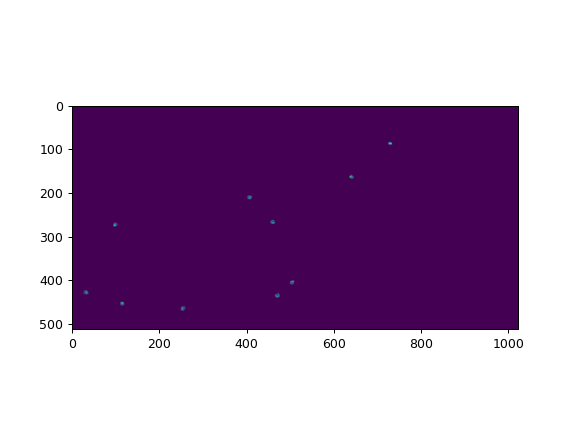

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [10]:
%matplotlib notebook

display_toggle_image_stack((sf_all[0][:10].sum(0),sf_N_aligned[:10].sum(0)))

In [17]:
sf_N_iscell = sf_N_aligned[iscell]

In [18]:
np.save(dir_dayN_analysis / 'alignment_indices.npy', alignment_indices)

In [20]:
h5_handling.simple_save(
    {'spatial_footprints': sf_N_iscell}, 
    dir_dayN_analysis / 'spatial_footprints_aligned.h5',
    write_mode='w'
)

In [21]:
str(dir_dayN_analysis / 'spatial_footprints_aligned.h5')

'D:\\RH_local\\data\\scanimage data\\round 5 experiments\\mouse 2_6\\20210410_test\\analysis_lastNight\\spatial_footprints_aligned.h5'

<IPython.core.display.Javascript object>


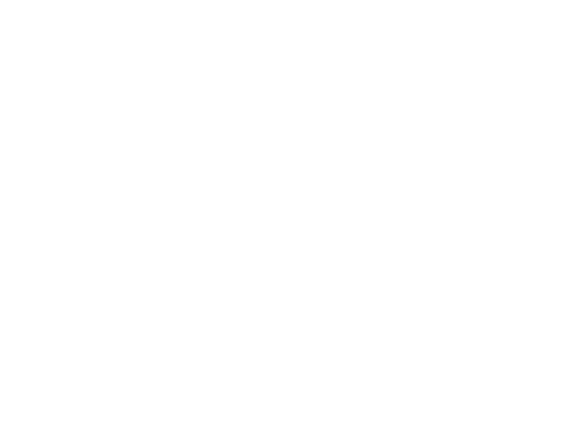

NameError: name 'image_processing' is not defined

In [27]:
meanIm = ops_all[1]['meanImg']
sf = sf_N_iscell

plt.figure()
plt.imshow(image_processing)